In [1]:
%matplotlib notebook

import time
import sys
import numpy as np
from collections import OrderedDict
from matplotlib import pyplot as plt
import os

# import sys

paths = [
# #     r"C:\Users\Administrator\Code\qcodes_wp",
    r"C:\Users\Administrator\Code\qcodes_jens",
    r"C:\Users\Administrator\Code\pysweep2.0",
]

for p in paths:
    if p not in sys.path:
        sys.path.append(p)

import qcodes
from qcodes.instrument_drivers.QuTech.IVVI import IVVI
from qcodes.instrument_drivers.stanford_research.SR865 import SR865
from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A


from pysweep import measurement
from pysweep import sweep, Measurement
from pysweep import data_plot

pyqtgraph plotting not supported, try "from qcodes.plots.pyqtgraph import QtPlot" to see the full error


In [2]:
import h5py

In [3]:
Measurement.use_storage("np")

In [4]:
def create_inst(cls, name, *arg, **kw):
    force_new = kw.pop('force_new_instance', False)
    
    try:
        return cls(name, *arg, **kw)
    except KeyError:
        print("Instrument {} already exists.".format(name))
        if force_new:
            qcodes.Instrument._all_instruments[name]().close()
            return cls(name, *arg, **kw)
            
        return qcodes.Instrument._all_instruments[name]()

In [5]:
ivvi = IVVI("ivvi", "ASRL5::INSTR")
sr1 = SR865("sr1", "GPIB0::3::INSTR")
key = Keysight_34465A("key1", "USB0::0x2A8D::0x0101::MY57503596::INSTR")



C:\Users\Administrator\Code\qcodes_jens\qcodes\instrument\parameter.py:182: UserWarning: Delay kwarg is deprecated. Replace with inter_delay or post_delay as needed
  warnings.warn("Delay kwarg is deprecated. Replace with "


Initialized IVVI-rack in 0.43s
Connected to: Stanford_Research_Systems SR860 (serial:003104, firmware:V1.47) in 0.12s
Connected to: Keysight Technologies 34465A (serial:MY57503596, firmware:A.02.14-02.40-02.14-00.49-03-01) in 0.20s


C:\Users\Administrator\Code\qcodes_jens\qcodes\instrument\parameter.py:207: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '


In [22]:
from qcodes.instrument_drivers.AlazarTech.ATS9360 import AlazarTech_ATS9360
alazar = create_inst(AlazarTech_ATS9360, 'alazar')

from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A
RF = create_inst(RohdeSchwarz_SGS100A, 'RF', address="TCPIP0::169.254.2.20")
LO = create_inst(RohdeSchwarz_SGS100A, 'LO', address="TCPIP0::169.254.234.107")

from qcodes.instrument_drivers.rigol.DG4000 import Rigol_DG4000
fg = create_inst(Rigol_DG4000, 'fg', address="TCPIP0::169.254.190.44::inst0::INSTR")


Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110525, firmware:3.1.19.15-3.50.124.67) in 0.03s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110524, firmware:3.1.19.15-3.50.124.67) in 0.03s
Connected to: Rigol Technologies DG4062 (serial:DG4E163251554, firmware:00.01.09) in 0.04s


In [23]:
station = qcodes.Station(key, ivvi, sr1, RF, LO, alazar, fg)
Measurement.set_station(station)

C:\Users\Administrator\Code\qcodes_jens\qcodes\instrument\parameter.py:614: UserWarning: set_validator is deprected use `inst.vals = MyValidator` instead
  "set_validator is deprected use `inst.vals = MyValidator` instead")


In [24]:
for i in range(1,16):
    ivvi.parameters['dac{}'.format(i)].set_step(0.5)
    ivvi.parameters['dac{}'.format(i)].set_delay(0.001)

ivvi.dac1.set_delay(0.001)
ivvi.dac1.set_step(20)
ivvi.dac6.set_delay(0.001)
ivvi.dac6.set_step(5)
ivvi.dac8.set_delay(0.001)
ivvi.dac8.set_step(5)
ivvi.dac12.set_delay(0.001)
ivvi.dac12.set_step(5)
ivvi.dac4.set_delay(0.001)
ivvi.dac4.set_step(5)

C:\Users\Administrator\Code\qcodes_jens\qcodes\instrument\parameter.py:512: UserWarning: set_step is deprecated use step property as in `inst.step = stepvalue` instead
  "set_step is deprecated use step property as in `inst.step = "
C:\Users\Administrator\Code\qcodes_jens\qcodes\instrument\parameter.py:524: UserWarning: set_delay is deprecated use inter_delay or post_delay property as in `inst.inter_delay = delayvalue` instead
  "set_delay is deprecated use inter_delay or post_delay property "


In [25]:
from qcodes.instrument_drivers.AlazarTech.acq_controllers import ATS9360Controller
from qcodes.instrument_drivers.AlazarTech.acq_controllers.\
    alazar_channel import AlazarChannel

class BaseMeasurement(object):
    
    def __init__(self, station):
        self.station = station
        

        


class AlazarMeasurement(BaseMeasurement):
    
    controller_cls = ATS9360Controller
    
    def __init__(self, *arg, **kw):
        super().__init__(*arg, **kw)
        
        self.int_time = 0.1 # [s]
        self.int_delay = 1e-6 # [s]
        self.ifrq = 8e6
        
        self.nchans = 2
        self.sample_rate = int(1e9)
        self.trigger_source1 = 'CHANNEL_A'
        self.demod = False
        self.integrate_samples = False
        self.average_records = False
        self.average_buffers = True
        self.navgs = 1
        self.records_per_buffer = 1

        
    def setup_channels(self, **kw):
        self.chans = []
        for c in ['A', 'B']:
            _chan = AlazarChannel(self.station.alazar_ctl,
                                  'chan'+c, 
                                  demod=self.demod,
                                  integrate_samples=self.integrate_samples,
                                  average_records=self.average_records,
                                  average_buffers=self.average_buffers)
            self.station.alazar_ctl.channels.append(_chan)
            self.chans.append(_chan)
            
            if self.demod:
                _chan.demod_freq(self.ifrq)
                _chan.demod_type('IQ')
        
        self.station.alazar_ctl.int_time(self.int_time)
        self.station.alazar_ctl.int_delay(self.int_delay)
        print("Number of samples per record:", 
              self.station.alazar_ctl.samples_per_record())
        
        for c, n in zip(self.chans, ['A', 'B']):
            c.num_averages(self.navgs)
            if not self.average_records:
                c.records_per_buffer(self.records_per_buffer)
            c.alazar_channel(n)
            c.prepare_channel()
        
    
    def setup_alazar(self, **kw):
        if hasattr(self.station, 'alazar_ctl'):
            del station.components['alazar_ctl']

        _ctl = create_inst(self.controller_cls, 'alazar_ctl',
                           alazar_name='alazar', filter='ave', 
                           force_new_instance=True)
        self.station.add_component(_ctl)
        
        self.station.alazar.config(
              clock_source='INTERNAL_CLOCK',
              sample_rate=self.sample_rate,
              clock_edge='CLOCK_EDGE_RISING',
              decimation=1,
              coupling=['DC','DC'],
              channel_range=[.4,.4],
              impedance=[50,50],
              trigger_operation='TRIG_ENGINE_OP_J',
              trigger_engine1='TRIG_ENGINE_J',
              trigger_source1=self.trigger_source1, #'EXTERNAL',  # 'CHANNEL_A',
              trigger_slope1='TRIG_SLOPE_POSITIVE',
              trigger_level1=128+2,
              trigger_engine2='TRIG_ENGINE_K',
              trigger_source2='DISABLE',
              trigger_slope2='TRIG_SLOPE_POSITIVE',
              trigger_level2=128,
              external_trigger_coupling='DC',
              external_trigger_range='ETR_2V5',
              trigger_delay=0,
              timeout_ticks=0,
              aux_io_mode='AUX_IN_AUXILIARY', # AUX_IN_TRIGGER_ENABLE for seq mode on
              aux_io_param='NONE' # TRIG_SLOPE_POSITIVE for seq mode on
              )

        self.setup_channels()
        

    def acquire(self):
        return self.station.alazar_ctl.channels.data()
           

In [43]:
import time
from collections import OrderedDict

Measurement.set_station(station)
Measurement.use_storage("np")

class RFSETMeasurement(AlazarMeasurement):
    
    def __init__(self, *arg, **kw):
        super().__init__(*arg, **kw)
        
        self.trigger_source1 = 'EXTERNAL'

    
    def _setup_run(self, station, namespace):
        station.RF.power(-55)
#         station.RF.power(-44)
        station.LO.power(10)
#         station.RF.frequency(1.398e9)
#         station.LO.frequency(1.398e9 + self.ifrq)
        station.RF.frequency(538.2e6)
        station.LO.frequency(538.2e6 + self.ifrq)
#         station.RF.frequency(1.040e9)
#         station.LO.frequency(1.040e9 + self.ifrq)
    
    def _cleanup_run(self, station, namespace):
#         station.RF.frequency(538.2e6)
#         station.LO.frequency(538.2e6 + self.ifrq)
#         station.RF.frequency(1.398e9)
#         station.LO.frequency(1.398e9 + self.ifrq)
        station.RF.frequency(1.040e9)
        station.LO.frequency(1.040e9 + self.ifrq)
    
    
    def _msmt(self, station, namespace):
        f0 = station.RF.frequency()
        station.LO.frequency(f0 + self.ifrq)
        time.sleep(1e-3)
        f1 = station.LO.frequency()
        A, B = station.alazar_ctl.channels.data()
        #DMM = key.volt()/1e7
        
        return OrderedDict({
            "chanA_I" : {"unit" : "V", "value" : A.real},
            "chanA_Q" : {"unit" : "V", "value" : A.imag},
            "chanB_I" : {"unit" : "V", "value" : B.real},
            "chanB_Q" : {"unit" : "V", "value" : B.imag},
            "abs" : {"unit" : "V", "value" : (abs(A)**2 + abs(B)**2)**.5, },
            "chanA_phase" : {"unit" : "deg", "value" : np.angle(A, deg=True) },
            "chanB_phase" : {"unit" : "deg", "value" : np.angle(B, deg=True) },
            "delta_phase" : {"unit" : "deg", "value" : np.angle(A, deg=True) - np.angle(B, deg=True) },
            #"current" : {"unit" : "A", "value" : DMM, },
        })
        

class SETResonanceScan(RFSETMeasurement):
    
    def __init__(self, *arg, **kw):
        super().__init__(*arg, **kw)
        
        self.integrate_samples = True
        self.demod = True
        self.average_records = True    

    def run(self):
        m = Measurement(self._setup_run, self._cleanup_run, 
                (sweep(self.station.ivvi.dac1, np.linspace(-500, 500, 51)),
                 sweep(self.station.ivvi.dac10, np.linspace(0, 10, 101)),                                  
                 self._msmt)
            )
        return m.run()


In [72]:
station.ivvi.dac1(100)
station.ivvi.dac4(-900)
station.ivvi.dac6(-900)
m = SETResonanceScan(station)
m.int_time = 50e-6
m.ifrq = 8e6
m.setup_alazar()
ret = m.run()

Instrument alazar_ctl already exists.
Number of samples per record: 65536


C:\Users\Administrator\Code\qcodes_jens\qcodes\instrument\parameter.py:214: UserWarning: Wrapping set method, original set method will not be directly accessible. It is recommended to define set_raw in your subclass instead.
  warnings.warn('Wrapping set method, original set method will not '
C:\Users\Administrator\Code\qcodes_jens\qcodes\instrument\parameter.py:1092: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')


In [37]:
station.RF.power()

-55.0

In [27]:
class SETBiasSweep(RFSETMeasurement):
    
    def __init__(self, *arg, **kw):
        super().__init__(*arg, **kw)
        
        self.integrate_samples = True
        self.demod = True
        self.average_records = True
        
    def run(self):
        m = Measurement(self._setup_run, self._cleanup_run, 
                (sweep(self.station.ivvi.dac10, np.linspace(0, 20, 201)),
                 self._msmt)
            )
        return m.run()
        


In [28]:
class TrigController(ATS9360Controller):
    fg = None
    
    def pre_acquire(self):
        time.sleep(1e-3)
        self.fg.ch1_output_enabled(True) 
        
    def post_acquire(self):
        self.fg.ch1_output_enabled(False)
        time.sleep(5e-3)
        return super().post_acquire()

In [146]:
station.ivvi.dac4(-905)
station.ivvi.dac5(-615)
station.ivvi.dac6(-850)
station.ivvi.dac1(0)
station.ivvi.dac9(0)

In [ ]:
class SETAWGGateSweep(RFSETMeasurement):
    
    controller_cls = TrigController
    
    def __init__(self, *arg, **kw):
        super().__init__(*arg, **kw)
        
        self.records_per_buffer = None
        self.integrate_samples = True
        self.demod = True
        self.average_records = False
        
    def _setup_run(self, station, namespace):
        station.fg.ch1_output_enabled(False)
    
    def _cleanup_run(self, station, namespace):
        station.fg.ch1_output_enabled(False)
        
    def run(self):
        m = Measurement(self._setup_run, self._cleanup_run, 
#                 (sweep(self.station.ivvi.dac1, [-200]), # np.linspace(-600, 1400, 101)),
                (sweep(self.station.ivvi.dac7, np.linspace(-2000, 2000, 101)),
                 self._msmt)
            )
        return m.run()

for juice in np.arange(-45,-15,5):
    station.RF.power(float(juice))
    
    fg.ch1_output_enabled(False)
    station.fg.ch1_frequency(40)
    TrigController.fg = station.fg

    m = SETAWGGateSweep(station)
    m.records_per_buffer = 200
    m.int_time = 50e-6
    m.navgs = 1
    m.ifrq = 8e6
    m.sample_rate = int(1e8)
    m.setup_alazar()

    ret = m.run()
    fn = ret.data_prefix + r"_data.h5"
    with h5py.File(fn, 'a') as f:
        f['data'] = ret.output()

Instrument alazar_ctl already exists.
Number of samples per record: 8192


C:\Users\Administrator\Code\qcodes_jens\qcodes\instrument\parameter.py:214: UserWarning: Wrapping set method, original set method will not be directly accessible. It is recommended to define set_raw in your subclass instead.
  warnings.warn('Wrapping set method, original set method will not '
C:\Users\Administrator\Code\qcodes_jens\qcodes\instrument\parameter.py:1092: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')


Instrument alazar_ctl already exists.
Number of samples per record: 8192


In [11]:
#Set some ramp rates for the DACs which aren't too painfully slow
def setup(station, namespace): 
    return {}

def cleanup(station, namespace): 
    return {}

   
def dc_measurement(station, namespace):
    
    #if hasattr(namespace, 't0'):
        #print('time since last point: {:.3f}'.format((time.time()-namespace.t0)*1e3))
    namespace.t0 = time.time()
    
    S1_gain = 1 # for now 
    NW_gain = 1e7 # Gain of current amp in V/A
    V_range = 1e-3 #Gain factor of voltage source module in V/V
    
    NW_res = 26400 + NW_gain*1e-4+100
    
    t0 = time.time()
    k1 = station.key1.volt()
    t1 = time.time() - t0
    #print("voltage readout took {:.3f} ms".format(t1 * 1e3))
    
    k1_scaled = k1/NW_gain
    #k2 = station.key2.volt()
    #k2_scaled = k2/S1_gain
   
    t0 = time.time()
    lockin1_x = station.sr1.X()
    lockin1_p = station.sr1.P()
    t1 = time.time() - t0
    #print("lock-in readout took {:.3f} ms".format(t1 * 1e3))
    
    if lockin1_x == 0:
        processed1 = 1e99
    else:
        processed1 = station.sr1.amplitude()*V_range*0.01 / (lockin1_x/NW_gain)-NW_res
    
    return OrderedDict({
        "Current": {"unit": "A", "value": k1_scaled}, 
        "k1": {"unit": "V", "value": k1},
        #"k2 scaled": {"unit": "V", "value": k2_scaled}, 
        #"k2": {"unit": "V", "value": k2},
        "lockin1_x": {"unit": "V", "value": lockin1_x}, 
        "lockin1_p": {"unit": "deg", "value": lockin1_p}, 
        "processed1": {"unit": "Ohm", "value": processed1}, 
        "conductance": {"unit": "e^2/h", "value": 12906/processed1}
    })

In [17]:
sr1.amplitude(1.5)

In [24]:
station.ivvi.dac4(-900)
station.ivvi.dac6(-900)

In [26]:
station.ivvi.dac7(0)
station.ivvi.dac8(0)
station.ivvi.dac9(0)
measure = Measurement(
    setup, 
    cleanup, 
    (
        sweep(station.ivvi.dac1, np.linspace(-500, 500, 101)),
        sweep(station.ivvi.dac10, np.linspace(0, 20, 101)),
        dc_measurement,
    )
).run()

In [88]:
sr1.amplitude(1)

In [81]:
station.ivvi.set_dacs_zero()

In [49]:
fn1 = r"C:\Users\Administrator\Code\qcodes_testing\qcodes_testing\data\2017-12\2017-12-14\154617\2017-12-14_154617.dat"
d1 = np.genfromtxt(fn1, delimiter='\t')

fn2 = r"C:\Users\Administrator\Code\qcodes_testing\qcodes_testing\data\2017-12\2017-12-14\154711\2017-12-14_154711.dat"
d2 = np.genfromtxt(fn2, delimiter='\t')

<IPython.core.display.Javascript object>


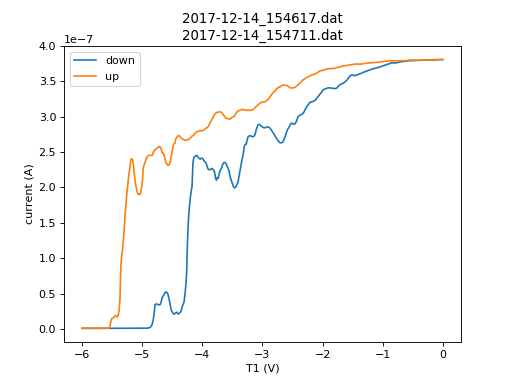

Text(0.5,1,'2017-12-14_154617.dat\n2017-12-14_154711.dat')

In [50]:
from matplotlib import pyplot as plt
import os

fig, ax = plt.subplots(1,1)
ax.plot(d1[:,0] / 200, d1[:,8], label='down')
ax.plot(d2[:,0] / 200, d2[:,8], label='up')
ax.set_ylabel('current (A)')
ax.set_xlabel('T1 (V)')

ax.legend()
ax.set_title(os.path.split(fn1)[1] + "\n" + os.path.split(fn2)[1])

In [64]:
1e-6/(6.28*np.sqrt(105e-9*0.24e-12))

1003.0904273068662

In [62]:
1/(4*3.14**2*310e-9*581e6**2)

2.4230744259209855e-13

In [136]:
for i in np.arange(-560,-590,-5):
    print(float(i))

-560.0
-565.0
-570.0
-575.0
-580.0
-585.0
